# 라이브러리


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터 불러오기

In [2]:
url = 'https://raw.githubusercontent.com/pykwon/python/refs/heads/master/testdata_utf8/HR_comma_sep.csv'
data = pd.read_csv(url)
print(data.head(3), data.shape) # (14999, 10)

   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales   

   salary  
0     low  
1  medium  
2  medium   (14999, 10)


In [3]:
le = LabelEncoder()
data['salary2'] = le.fit_transform(data['salary'])
data = pd.get_dummies(data, columns=['sales'], drop_first=True)

feature = data.drop(['salary', 'salary2'], axis=1)
print(feature.head(2))
print()

label = data['salary2']
print(label.head(2))

   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   

   time_spend_company  Work_accident  left  promotion_last_5years  \
0                   3              0     1                      0   
1                   6              0     1                      0   

   sales_RandD  sales_accounting  sales_hr  sales_management  sales_marketing  \
0        False             False     False             False            False   
1        False             False     False             False            False   

   sales_product_mng  sales_sales  sales_support  sales_technical  
0              False         True          False            False  
1              False         True          False            False  

0    1
1    2
Name: salary2, dtype: int64


# 랜덤포레스트

(11999, 17) (3000, 17) (11999,) (3000,)
rfmodel acc: 0.6163


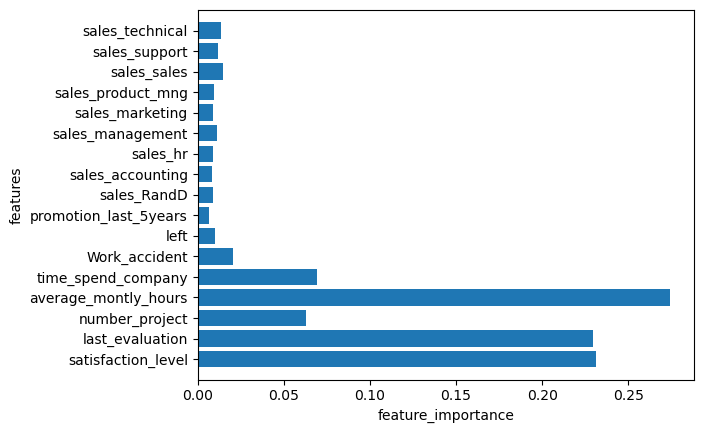

In [4]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

rfmodel = RandomForestClassifier().fit(x_train, y_train)
rfpred = rfmodel.predict(x_test)
print('rfmodel acc: {0:.4f}'.format(accuracy_score(y_test, rfpred)))    # 0.6117

n_features = feature.shape[1]
plt.barh(range(n_features), rfmodel.feature_importances_, align='center')
plt.xlabel('feature_importance')
plt.ylabel('features')
plt.yticks(np.arange(n_features), feature.columns)
plt.ylim(-1, n_features)
plt.show()
plt.close()

# 딥러닝 모델 데이터

In [5]:
x_data = data.drop(['salary', 'salary2', 'sales_RandD', 'sales_accounting', 'sales_hr', 'sales_management', 'sales_marketing', 'sales_product_mng', 'sales_sales', 'sales_support', 'sales_technical', 'Work_accident', 'left', 'promotion_last_5years'], axis=1)
print(x_data.head(2))
print()

y_data = data['salary2']
print(label.head(2))
print()

nb_classes = len(set(y_data))
print('classes 범주: ', nb_classes)
print()

# train / test
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape) # (11999, 5) (3000, 5) (11999,) (3000,)

   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   

   time_spend_company  
0                   3  
1                   6  

0    1
1    2
Name: salary2, dtype: int64

classes 범주:  3

(11999, 5) (3000, 5) (11999,) (3000,)


# 딥러닝 모델 정의

In [6]:
# model
model = Sequential([
    Input(shape=(x_data.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(nb_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,563 (10.01 KB)

 Trainable params: 2,563 (10.01 KB)

 Non-trainable params: 0 (0.00 B)

# 딥러닝 모델 학습

In [7]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# restore_best_weights=True: 학습 종료 후 가장 좋은 'val_loss'를 기록한 epoch의 가중치

checkpoint = ModelCheckpoint('best_zoom_model.keras', monitor='val_loss', save_best_only=True)

In [8]:
# history = model.fit(x_train, y_train, epochs=1000, validation_split=0.2, callbacks=[early_stop, checkpoint], verbose=1)
history = model.fit(x_train_scaled, y_train, epochs=1000, validation_split=0.2, callbacks=[early_stop, checkpoint], verbose=1)

Epoch 1/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4876 - loss: 0.9314 - val_accuracy: 0.4871 - val_loss: 0.9070
Epoch 2/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4941 - loss: 0.9167 - val_accuracy: 0.4888 - val_loss: 0.9063
Epoch 3/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4956 - loss: 0.9163 - val_accuracy: 0.4892 - val_loss: 0.9082
Epoch 4/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4988 - loss: 0.9130 - val_accuracy: 0.4950 - val_loss: 0.9046
Epoch 5/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4935 - loss: 0.9125 - val_accuracy: 0.4950 - val_loss: 0.9030
Epoch 6/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4932 - loss: 0.9118 - val_accuracy: 0.4913 - val_loss: 0.9040
Epoch 7/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4956 - loss: 0.9103 - val_accuracy: 0.4913 - val_loss: 0.9038
Epoch 8/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4922 - loss: 0.9101 - 

# 딥러닝 모델 평가

In [9]:
# loss, acc = model.evaluate(x_test, y_test, verbose=0)
loss, acc = model.evaluate(x_test_scaled, y_test, verbose=0)
print(f'최종 평가: Loss:{loss:.4f}, Accuracy:{acc:.4f}')

최종 평가: Loss:0.9036, Accuracy:0.4930


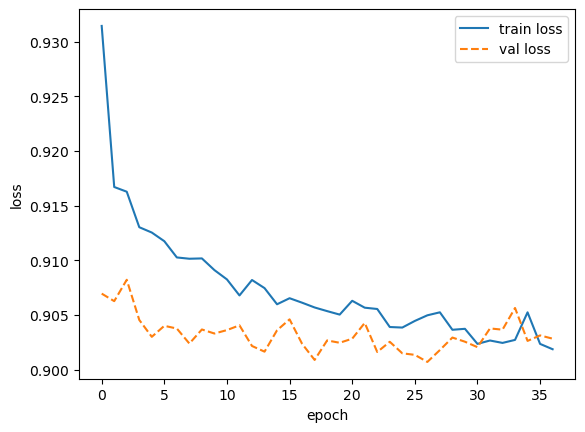

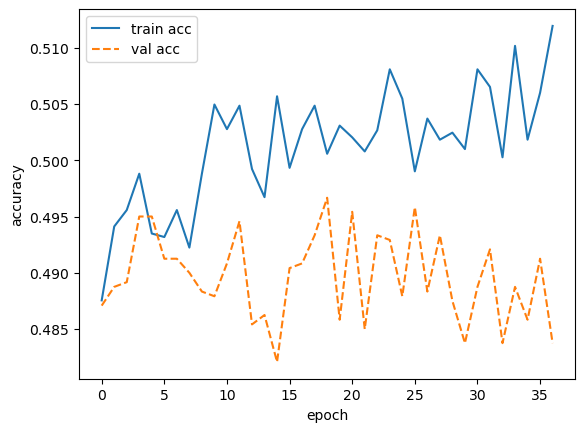

In [10]:
# 학습 곡선 시각화
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], '--',label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.clf()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], '--', label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.close()